In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.spatial import distance
from gemelli.rpca import joint_rpca
from biom import Table
from statannotations.Annotator import Annotator
from skbio.stats.distance import permanova, permdisp
from skbio import OrdinationResults, DistanceMatrix
from sklearn.model_selection import train_test_split
from gemelli.joint_ctf import joint_ctf
from gemelli.ctf import ctf_table_processing
from gemelli.preprocessing import build_sparse

%matplotlib inline

In [2]:
joint_rpca_path = '/Users/bec5786/NYU Langone Health Dropbox/Bianca Cordazzo Vargas/Shenhav_Lab/IMiC/Code/Joint-RPCA/'

In [3]:
#load metadata
misame_metadata = pd.read_csv("{}output/all_tps/misame_metadata_vitae.csv".format(joint_rpca_path), index_col=0)

#load targeted metabolomics data
allen_macro = pd.read_csv("{}output/all_tps/misame_macro_all_raw.csv".format(joint_rpca_path), index_col=0)
allen_micro = pd.read_csv("{}output/all_tps/misame_micro_vitae_raw.csv".format(joint_rpca_path), index_col=0)
bode_hmos = pd.read_csv("{}output/all_tps/misame_hmo_all_raw.csv".format(joint_rpca_path), index_col=0)
biocrates = pd.read_csv("{}output/all_tps/misame_biocrates_all_raw.csv".format(joint_rpca_path), index_col=0)

#load top 104 untargeted metabolites (optional)
untargeted = pd.read_csv("{}output/all_tps/misame_untargeted_sapient.csv".format(joint_rpca_path), index_col=0)
untargeted = untargeted.loc[misame_metadata.index]

In [4]:
#keep subsets with at least 2 samples
ids_to_keep = misame_metadata['SubjectID'].value_counts()[misame_metadata['SubjectID'].value_counts() > 1].index

#subset all data
misame_metadata = misame_metadata.loc[misame_metadata['SubjectID'].isin(ids_to_keep)]
allen_macro = allen_macro.loc[misame_metadata.index]
allen_micro = allen_micro.loc[misame_metadata.index]
bode_hmos = bode_hmos.loc[misame_metadata.index]
biocrates = biocrates.loc[misame_metadata.index]
untargeted = untargeted.loc[misame_metadata.index]

In [5]:
allen_macro_tf = allen_macro.apply(np.sqrt, axis=0) #power transformation
allen_macro_tf = allen_macro_tf.apply(zscore, axis=0) #centering

allen_micro_tf = allen_micro.apply(np.sqrt, axis=0)
#allen_micro_tf = allen_micro_tf.apply(zscore, axis=0)

bode_hmos_tf = bode_hmos.apply(np.sqrt, axis=0)
bode_hmos_tf = bode_hmos_tf.apply(zscore, axis=0)

biocrates_tf = biocrates.apply(np.sqrt, axis=0)
biocrates_tf = biocrates_tf.apply(zscore, axis=0)

#untargeted metabolomics data
untargeted_tf = untargeted.apply(np.sqrt, axis=1)
untargeted_tf = untargeted_tf.apply(zscore, axis=1)

In [6]:
#conver to biom tables
allen_macro_tf = Table(allen_macro_tf.values.T, 
                        observation_ids=allen_macro_tf.columns.to_list(), 
                        sample_ids=allen_macro_tf.index.to_list())
allen_micro_tf = Table(allen_micro_tf.values.T, 
                        observation_ids=allen_micro_tf.columns.to_list(), 
                        sample_ids=allen_micro_tf.index.to_list())
bode_hmos_tf = Table(bode_hmos_tf.values.T, 
                     observation_ids=bode_hmos_tf.columns.to_list(), 
                     sample_ids=bode_hmos_tf.index.to_list())
biocrates_tf = Table(biocrates_tf.values.T, 
                     observation_ids=biocrates_tf.columns.to_list(), 
                     sample_ids=biocrates_tf.index.to_list())
untargeted_tf = Table(untargeted_tf.values.T,
                      observation_ids=untargeted_tf.columns.to_list(),
                      sample_ids=untargeted_tf.index.to_list())

In [7]:
allen_micro_tf.to_dataframe().isnull().sum().sum() #check for missing values


0

In [8]:
np.count_nonzero(np.isnan(allen_micro_tf.to_dataframe()))

0

In [14]:
misame_metadata.Timepoint.value_counts()

2    273
3    272
1    261
Name: Timepoint, dtype: int64

In [9]:
(subject_loads, feature_loads, 
 state_loads, subject_lambdas,
 var_explained, feature_covs) = joint_ctf(tables=[allen_micro_tf],
                                          sample_metadatas=[misame_metadata],
                                          modality_ids=['Micronutrients'],
                                          individual_id_column='SubjectID',
                                          state_column='Timepoint')

print(subject_lambdas)
print(var_explained.T)

Calculate components for component_1
Reached convergence in 8 iterations
Calculate components for component_2
Reached convergence in 6 iterations
Calculate components for component_3
Reached convergence in 5 iterations
                component_1  component_2  component_3
Micronutrients  2598.587544  2595.314193    1234.6597
               component_1  component_2  component_3
var_explained     0.600395     0.377269     0.022336


In [8]:
# tensors = {}
# for table, metadata, mod_id in zip([allen_micro_tf, biocrates_tf],
#                                    [misame_metadata, misame_metadata],
#                                    ['Micronutrients', 'Biocrates']):

#     print(mod_id)
#     # check the table for validity and then filter
#     process_results = ctf_table_processing(table,
#                                             metadata,
#                                             'SubjectID',
#                                             ['Timepoint'],
#                                             min_sample_count=0,
#                                             min_feature_count=0,
#                                             min_feature_frequency=0,
#                                             feature_metadata=None)
#     table = process_results[0]
#     metadata = process_results[1]

#     if isinstance(table, Table):
#         table = pd.DataFrame(table.matrix_data.toarray(),
#                              table.ids('observation'),
#                              table.ids('sample'))

#     if np.count_nonzero(np.isinf(table.values)) != 0:
#             raise ValueError('Table contains either np.inf or -np.inf.')
#     if np.count_nonzero(np.isnan(table.values)) != 0:
#         raise ValueError('Table contains np.nan or missing.')
    
#     # build the sparse tensor format
#     tensor = build_sparse()
#     tensor.construct(table,
#                      metadata,
#                      'SubjectID',
#                      'Timepoint',
#                      transformation=lambda x: x,
#                      pseudo_count=0,
#                      branch_lengths=None,
#                      replicate_handling='sum',
#                      svd_centralized=True,
#                      n_components_centralize=1)
#     tensors[mod_id] = tensor

In [11]:
#keep only instance of each subject
misame_metadata_plot = misame_metadata.drop_duplicates(subset='SubjectID')
#ord_plt = pd.concat([subject_loads['Micronutrients'], misame_metadata_plot.set_index('SubjectID')], axis=1, sort=True)
ord_plt = pd.concat([subject_loads, misame_metadata_plot.set_index('SubjectID')], axis=1, sort=True)

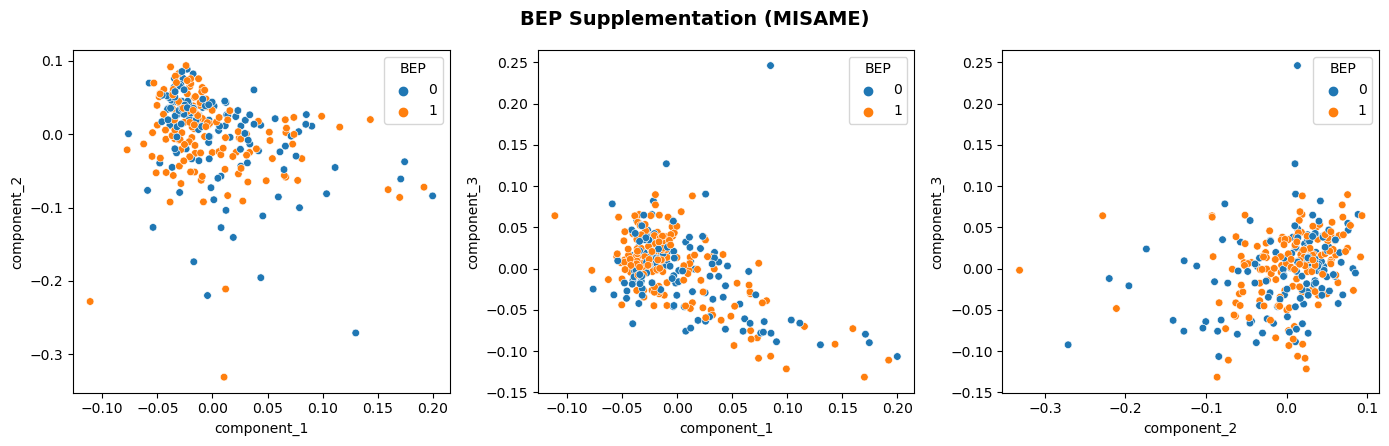

In [12]:
#sapient subset
fig, axn = plt.subplots(1, 3, figsize=(14,4.5))
phenotype = 'BEP' #BEP,WAZ_M04_binary_bins
axn = axn.flatten()
for ax, pcs in zip(axn, [['component_1', 'component_2',], ['component_1', 'component_3'], 
                         ['component_2', 'component_3']]):
    sns.scatterplot(x=pcs[0], y=pcs[1], hue=phenotype, #hue_order=hue_order, 
                    data=ord_plt, s=30, ax=ax)
plt.suptitle("BEP Supplementation (MISAME)", 
             color='black', weight='bold', fontsize=14)
plt.tight_layout()
plt.show()

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.944e-01 U_stat=1.046e+04
0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:5.988e-01 U_stat=1.011e+04
0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.287e-01 U_stat=8.723e+03


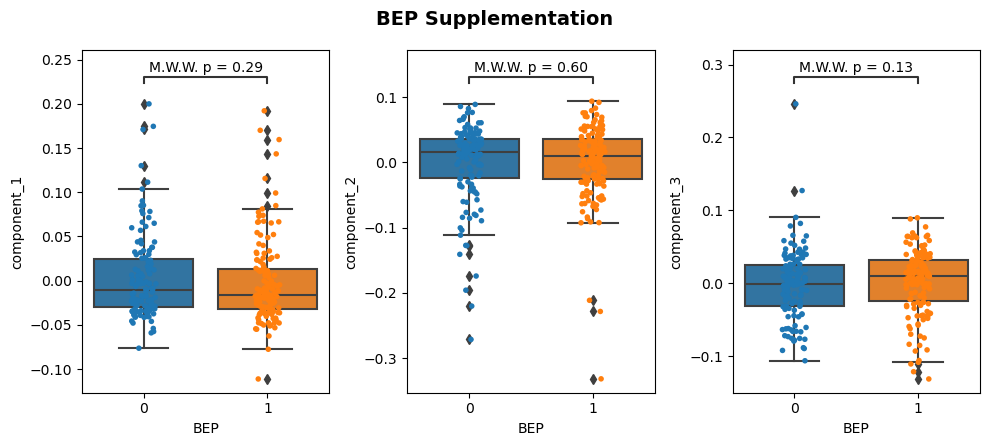

In [13]:
fig, axn = plt.subplots(1, 3, figsize=(10,4.5))
axn = axn.flatten()
phenotype = 'BEP'

for ax, pc in zip(axn, ['component_1', 'component_2', 'component_3']):
    sns.boxplot(x=phenotype, y=pc, data=ord_plt, ax=ax)
    #add points
    sns.stripplot(x=phenotype, y=pc, data=ord_plt, size=4, ax=ax)
    #add significance
    annotator = Annotator(ax, [(0,1)], x=phenotype, y=pc, data=ord_plt)
    annotator.configure(test="Mann-Whitney", text_format='simple').apply_and_annotate()
    
plt.suptitle("BEP Supplementation", 
             color='black', weight='bold', fontsize=14)
plt.tight_layout()

In [14]:
feature_loads['Micronutrients'].sort_values(by='component_1', ascending=True)

,component_1,component_2,component_3
K,-0.344254,0.117237,0.875224
P,-0.301235,0.033695,0.436694
Ca,-0.189449,-0.022373,0.196529
Mg,-0.027568,-0.012492,-0.052313
PA,-0.016217,-0.008349,0.013537
B3,-0.007361,0.010507,0.032651
B6,-0.003470,-0.002935,-0.001404
g-tocopherol,-0.002069,-0.000330,-0.002963
B2,-0.001994,0.000008,0.000538
Zn,-0.000811,0.000663,0.002947


In [17]:
test_mod1 = state_loads['Micronutrients'][['component_1', 'component_2', 'component_3']]

sgn_mod1 = np.sign(test_mod1.sum(axis=0))
print(sgn_mod1)

component_1    1.0
component_2    1.0
component_3    1.0
dtype: float64
